#  To analyze usage patterns and user retention.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import datetime

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, f1_score, precision_score,recall_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression


from sklearn import preprocessing


pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',20000)

## Load data set from local folder and inital data exploration

In [2]:
df = pd.read_csv('usage.csv')
df.columns

Index(['user', 'day', 'usage'], dtype='object')

In [3]:
len(df)

875243

In [4]:
df.head()

,user,day,usage
0,00097b5304ac028d14ec093cba2c41f76126fab4,0,0
1,00097b5304ac028d14ec093cba2c41f76126fab4,1,0
2,00097b5304ac028d14ec093cba2c41f76126fab4,2,0
3,00097b5304ac028d14ec093cba2c41f76126fab4,3,0
4,00097b5304ac028d14ec093cba2c41f76126fab4,4,0


In [5]:
len(df['user'].unique())

5149

In [6]:
df.isnull().any().any()

False

In [7]:
df.isnull().any()

user     False
day      False
usage    False
dtype: bool

In [8]:
df['usage'].value_counts()

0    589540
1    285703
Name: usage, dtype: int64

In [87]:
# df=df.set_index(pd.DatetimeIndex(df['day']))
# df.head()

In [88]:
# df=df.set_index('day')
# df.head()

### I wanted to look at the trends in the raw data so I pulled up information for one user

In [89]:
df_u1=df.loc[df['user'] == '00097b5304ac028d14ec093cba2c41f76126fab4']
len(df_u1)

176

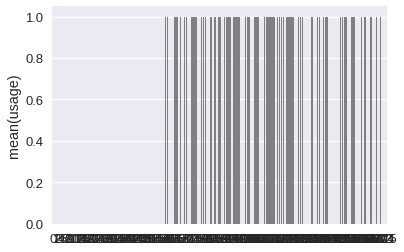

In [90]:
colors1 = ['grey' if x==True else 'red' for x in df_u1.usage]

sns.barplot(x=df_u1.index,y=df_u1.usage,palette=colors1)

### Plot the trend for  1 user

In [12]:
win = 30
rollMean = df_u1.usage.rolling(window=win, center=False).mean()
rollStd = df_u1.usage.rolling(window=win, center=False).std()

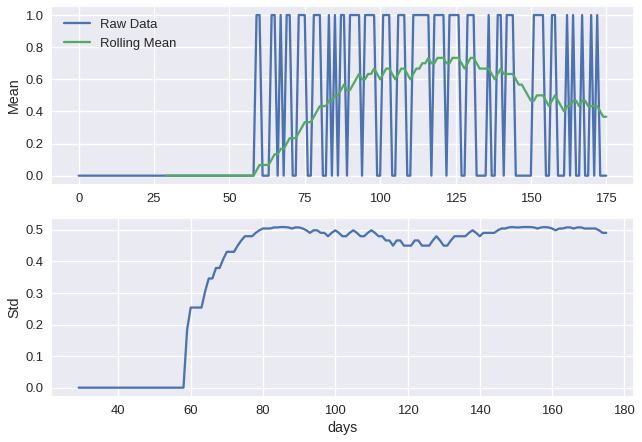

In [91]:
# plot the rolling stats
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df_u1.usage, label='Raw Data')
ax1.plot(rollMean, label='Rolling Mean')
ax1.set_ylabel('Mean')
ax1.legend()
ax2.plot(rollStd, label='Rolling Std')
ax2.set_xlabel('days')
ax2.set_ylabel('Std')
sns.despine()

## Find longest run where usage = 0 for 1 user (ref code from stackoverflow)

In [92]:
df_usr = df.loc[df['user']=='00097b5304ac028d14ec093cba2c41f76126fab4']
ts = pd.Series(df_usr['usage'])
ts2 = 1-ts
tsgroup = ts.cumsum()
consec_0 = ts2.groupby(tsgroup).transform(pd.Series.cumsum)
longest_no_usage_usr = consec_0.max()
print(longest_no_usage_usr)

59


## Longest run of no usage for all users

In [17]:
longest_no_usage_list = []

for usr in df['user'].unique():
    
    df_usr = df.loc[df['user']==usr]
    ts = pd.Series(df_usr['usage'])
    ts2 = 1-ts
    tsgroup = ts.cumsum()
    consec_0 = ts2.groupby(tsgroup).transform(pd.Series.cumsum)
    # print(consec_0.max())
    longest_no_usage_usr = consec_0.max()
    longest_no_usage_list.append(longest_no_usage_usr)
   

print(longest_no_usage_list)

[59, 11, 1, 101, 3, 5, 61, 4, 42, 70, 66, 22, 65, 68, 1, 0, 21, 227, 15, 1, 0, 205, 72, 55, 59, 4, 17, 1, 1, 9, 37, 104, 45, 39, 1, 74, 61, 2, 43, 29, 1, 37, 81, 47, 66, 5, 49, 4, 22, 208, 78, 73, 19, 8, 21, 8, 90, 1, 25, 9, 85, 12, 125, 83, 86, 44, 4, 35, 1, 77, 5, 17, 95, 64, 90, 17, 57, 34, 115, 3, 32, 7, 47, 9, 153, 34, 40, 11, 28, 23, 67, 189, 120, 1, 7, 9, 15, 1, 69, 47, 72, 6, 75, 10, 6, 15, 20, 8, 1, 15, 83, 53, 69, 1, 70, 78, 58, 5, 2, 13, 15, 3, 112, 3, 30, 7, 78, 14, 0, 60, 97, 90, 4, 0, 3, 15, 22, 62, 41, 57, 62, 45, 165, 1, 9, 9, 22, 7, 2, 66, 117, 1, 21, 34, 23, 2, 0, 56, 1, 44, 40, 9, 45, 1, 18, 40, 14, 10, 72, 65, 48, 55, 8, 47, 1, 23, 5, 61, 81, 5, 35, 0, 10, 48, 35, 21, 4, 5, 108, 16, 4, 5, 2, 4, 58, 183, 115, 5, 1, 84, 64, 51, 0, 8, 0, 8, 12, 137, 90, 71, 10, 67, 34, 65, 46, 37, 70, 3, 12, 120, 1, 18, 4, 148, 66, 55, 31, 21, 34, 40, 10, 2, 13, 33, 103, 32, 48, 67, 5, 24, 70, 37, 62, 6, 5, 82, 34, 8, 50, 1, 36, 67, 5, 2, 109, 6, 87, 2, 102, 1, 66, 5, 14, 36, 83, 7, 2,

In [61]:
df_unq_lou = pd.DataFrame(columns=['uniq_usr','longest_no_usage'])
df_unq_lou

,uniq_usr,longest_no_usage


In [62]:
df_unq_lou['longest_no_usage']=longest_no_usage_list


In [63]:
df_unq_lou['uniq_usr']=df['user'].unique()

In [64]:
df_unq_lou.head()

,uniq_usr,longest_no_usage
0,00097b5304ac028d14ec093cba2c41f76126fab4,59
1,002b862b2604247ecfe7c9dc9d5fa41811a93d3e,11
2,0036892c09cc30ab1dec9999eb43189af4dd71b4,1
3,0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,101
4,0048bc445cdbff2bba4963af21e881c8645a6cdb,3


### Overall Statistics

In [65]:
df_unq_lou.describe()

,longest_no_usage
count,5149.000000
mean,37.675277
std,40.054123
min,0.000000
25%,6.000000
50%,23.000000
75%,59.000000
max,272.000000


## Summary plot of longest run no usage

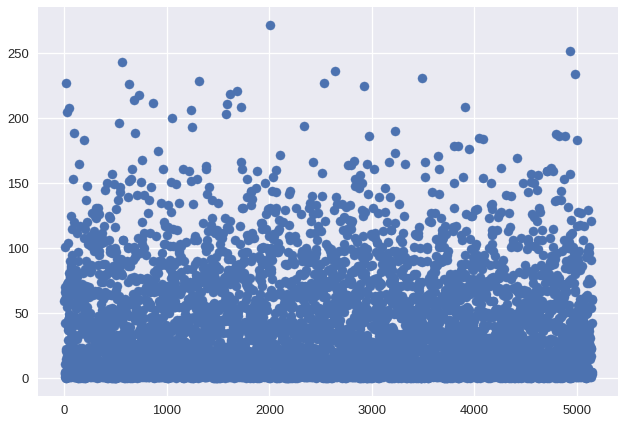

In [72]:
plt.scatter(df_unq_lou.index, df_unq_lou['longest_no_usage'])

# Derive 3 features based on the first 30 days of usage for each user

In [4]:
df_30=df.groupby('user').head(30)# group by to get first 30 days of each user
len(df_30)

144836

## 1. Compute total usage days for each user

In [5]:
days_used=df_30.groupby('user')['usage'].sum()
days_used=pd.DataFrame(days_used)
days_used.head(10)

,usage
user,
00097b5304ac028d14ec093cba2c41f76126fab4,0
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,14
0036892c09cc30ab1dec9999eb43189af4dd71b4,29
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,0
0048bc445cdbff2bba4963af21e881c8645a6cdb,22
004ac21e94c7a42e6c93835062602402056f2443,20
00510bfdb09f06057ffebc04b259a673dc38cb8b,29
00548c658c50f6254b0ab132ef22424579a0b0d0,27
0074824c7bc3ebea47f098c670947fe1422d5ad0,2


## 2. Compute longest no usage days for each user within first 30 days

In [12]:
longest_no_usage_list_30 = []

for usr in df_30['user'].unique():
    
    df_30_usr = df_30.loc[df_30['user']==usr]
    ts_30 = pd.Series(df_30_usr['usage'])
    ts2_30 = 1-ts_30
    tsgroup_30 = ts_30.cumsum()
    consec_0_30 = ts2_30.groupby(tsgroup_30).transform(pd.Series.cumsum)
    # print(consec_0.max())
    longest_no_usage_usr_30 = consec_0_30.max()
    longest_no_usage_list_30.append(longest_no_usage_usr_30)

In [13]:
days_used_mean=df_30.groupby('user')['usage'].mean()

## 3. Compute first day users started using

In [6]:
days_of_usage=df_30.loc[df_30['usage']==1]
first_day=days_of_usage.groupby('user').nth(0)
first_day.head(10)

,day,usage
user,,
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,44,1
0036892c09cc30ab1dec9999eb43189af4dd71b4,5,1
0048bc445cdbff2bba4963af21e881c8645a6cdb,147,1
004ac21e94c7a42e6c93835062602402056f2443,14,1
00510bfdb09f06057ffebc04b259a673dc38cb8b,175,1
00548c658c50f6254b0ab132ef22424579a0b0d0,214,1
0074824c7bc3ebea47f098c670947fe1422d5ad0,104,1
008bcb6164ffbf3839c8511b07412b4ded4d5ce1,289,1
008dff2bb55d5aef4de4a2a772a3a86cb1d7ba80,56,1


In [7]:
first_row=df_30.groupby('user').nth(0)
first_row.head(10)

,day,usage
user,,
00097b5304ac028d14ec093cba2c41f76126fab4,0,0
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,44,1
0036892c09cc30ab1dec9999eb43189af4dd71b4,4,0
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,56,0
0048bc445cdbff2bba4963af21e881c8645a6cdb,147,1
004ac21e94c7a42e6c93835062602402056f2443,13,0
00510bfdb09f06057ffebc04b259a673dc38cb8b,175,1
00548c658c50f6254b0ab132ef22424579a0b0d0,214,1
0074824c7bc3ebea47f098c670947fe1422d5ad0,97,0


In [9]:
#first_row.index.tolist()

In [21]:
first_day.index.tolist().index('0036892c09cc30ab1dec9999eb43189af4dd71b4')
first_day['day'][1]

5

In [32]:
first_day_all=[]

for i1, ur in enumerate(first_row.index.tolist()):
    try:
        i2 = first_day.index.tolist().index(ur)
        # print(first_day['day'][i2] - first_row['day'][i1] + 1)
        first_day_all.append(first_day['day'][i2] - first_row['day'][i1] + 1)
    except:
        # print('Missing')
        first_day_all.append(0)

# print(first_day_all)

In [38]:
print(len(first_day_all))
print(len(longest_no_usage_list_30))
print(len(days_used))


5149
5149
5149


In [46]:
days_used['first_day_all']=first_day_all
days_used['longest_no_usage_list_30']=longest_no_usage_list_30
days_used['user_id']=first_row.index.tolist()
days_used = days_used.rename(columns={'usage': 'sum_usage'})
days_used.head()

,sum_usage,first_day_all,longest_no_usage_list_30,user_id
user,,,,
00097b5304ac028d14ec093cba2c41f76126fab4,0,0,30,00097b5304ac028d14ec093cba2c41f76126fab4
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,14,1,8,002b862b2604247ecfe7c9dc9d5fa41811a93d3e
0036892c09cc30ab1dec9999eb43189af4dd71b4,29,2,1,0036892c09cc30ab1dec9999eb43189af4dd71b4
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,0,0,30,0040b11703e9dd8d7c8e5b8b46f64d20b642eb71
0048bc445cdbff2bba4963af21e881c8645a6cdb,22,1,3,0048bc445cdbff2bba4963af21e881c8645a6cdb


# Compute churn: 30 days of inactivity following the first 30 days of usage

### First compute usage sum for 60 days and substract the usage sum for 30 days. If the result is more than 1 assign 1 to that user. This forms the predictor values

In [11]:
df_60=df.groupby('user').head(60)
len(df_60)

273769

In [12]:
days_used_60=df_60.groupby('user')['usage'].sum()
days_used_60=pd.DataFrame(days_used_60)
days_used_60.head(10)

,usage
user,
00097b5304ac028d14ec093cba2c41f76126fab4,1
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,23
0036892c09cc30ab1dec9999eb43189af4dd71b4,58
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,1
0048bc445cdbff2bba4963af21e881c8645a6cdb,42
004ac21e94c7a42e6c93835062602402056f2443,34
00510bfdb09f06057ffebc04b259a673dc38cb8b,57
00548c658c50f6254b0ab132ef22424579a0b0d0,57
0074824c7bc3ebea47f098c670947fe1422d5ad0,3


In [16]:
ch_total=days_used_60['usage']-days_used['sum_usage']
ch_total=pd.DataFrame(ch_total, columns=['diff'])
ch_total.head(10)

,diff
user,
00097b5304ac028d14ec093cba2c41f76126fab4,1
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,9
0036892c09cc30ab1dec9999eb43189af4dd71b4,29
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,1
0048bc445cdbff2bba4963af21e881c8645a6cdb,20
004ac21e94c7a42e6c93835062602402056f2443,14
00510bfdb09f06057ffebc04b259a673dc38cb8b,28
00548c658c50f6254b0ab132ef22424579a0b0d0,30
0074824c7bc3ebea47f098c670947fe1422d5ad0,1


In [17]:
ch_bool=ch_total.copy()
ch_bool.loc[ch_bool['diff'] > 1, 'diff'] = 1
ch_bool.head(10)

,diff
user,
00097b5304ac028d14ec093cba2c41f76126fab4,1
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,1
0036892c09cc30ab1dec9999eb43189af4dd71b4,1
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,1
0048bc445cdbff2bba4963af21e881c8645a6cdb,1
004ac21e94c7a42e6c93835062602402056f2443,1
00510bfdb09f06057ffebc04b259a673dc38cb8b,1
00548c658c50f6254b0ab132ef22424579a0b0d0,1
0074824c7bc3ebea47f098c670947fe1422d5ad0,1


In [18]:
days_used['churn']=ch_bool['diff']
days_used.head(10)

,sum_usage,churn
user,,
00097b5304ac028d14ec093cba2c41f76126fab4,0,1
002b862b2604247ecfe7c9dc9d5fa41811a93d3e,14,1
0036892c09cc30ab1dec9999eb43189af4dd71b4,29,1
0040b11703e9dd8d7c8e5b8b46f64d20b642eb71,0,1
0048bc445cdbff2bba4963af21e881c8645a6cdb,22,1
004ac21e94c7a42e6c93835062602402056f2443,20,1
00510bfdb09f06057ffebc04b259a673dc38cb8b,29,1
00548c658c50f6254b0ab132ef22424579a0b0d0,27,1
0074824c7bc3ebea47f098c670947fe1422d5ad0,2,1


In [59]:
days_used.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5149 entries, 00097b5304ac028d14ec093cba2c41f76126fab4 to ffe49fb47ef4028061866472b8e9201763cc1816
Data columns (total 5 columns):
sum_usage                   5149 non-null int64
first_day_all               5149 non-null int64
longest_no_usage_list_30    5149 non-null int64
user_id                     5149 non-null object
churn                       5149 non-null int64
dtypes: int64(4), object(1)
memory usage: 241.4+ KB


In [86]:
days_used = days_used.reset_index(drop=True)

# Get features

In [87]:
X=days_used.drop(['user_id','churn'], axis=1)
print(X[0:10])

   sum_usage  first_day_all  longest_no_usage_list_30
0          0              0                        30
1         14              1                         8
2         29              2                         1
3          0              0                        30
4         22              1                         3
5         20              2                         4
6         29              1                         1
7         27              1                         1
8          2              8                        19
9          0              0                        30


In [88]:
y=days_used[['churn']].values.ravel()
print(y[0:10])

[1 1 1 1 1 1 1 1 1 0]


# Check for correlated features and drop highly correlated

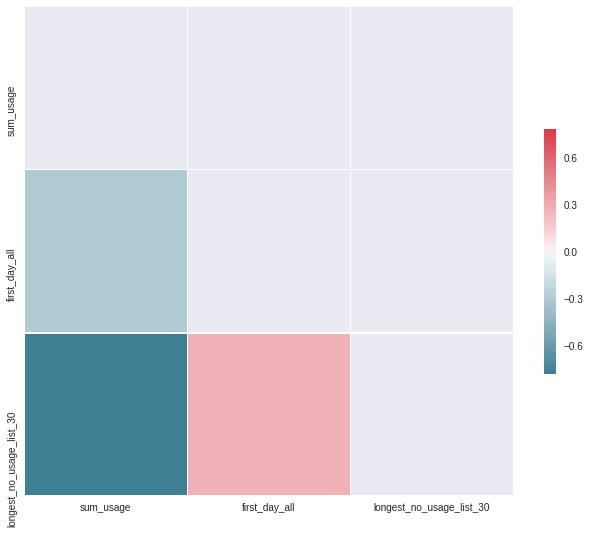

In [89]:

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [92]:
print(X[0:10])

   sum_usage  first_day_all  longest_no_usage_list_30
0          0              0                        30
1         14              1                         8
2         29              2                         1
3          0              0                        30
4         22              1                         3
5         20              2                         4
6         29              1                         1
7         27              1                         1
8          2              8                        19
9          0              0                        30


# Use first pass Random Forest to train classifier for categorical data

In [106]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y,
                                                   random_state = 0)
print ("X_train Shape :: ", X_train0.shape)
print ("X_test Shape :: ", X_test0.shape)
print ("y_train Shape :: ", y_train0.shape)
print ("y_test Shape :: ", y_test0.shape)


clf0 = RandomForestClassifier(n_estimators=120, criterion='entropy', max_depth=8,
                             min_samples_leaf=6,random_state=0).fit(X_train0, y_train0)

X_train Shape ::  (3861, 3)
X_test Shape ::  (1288, 3)
y_train Shape ::  (3861,)
y_test Shape ::  (1288,)


In [93]:
# Setup the hyperparameter grid, (not scaled data)
param_grid = {'C': np.logspace(-5, 8, 15)}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg,param_grid , cv=5)


# Fit it to the data
logreg_cv.fit(X_train0, y_train0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.05179474679231213}
Best score is 0.7961667961667962


In [94]:
class_pred = logreg_cv.predict(X_test0)

In [95]:
print("Testing accuracy is: ", accuracy_score(y_test0, class_pred))

Testing accuracy is:  0.796583850931677


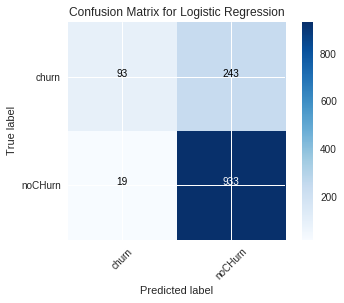

In [96]:
from sklearn.metrics import confusion_matrix
import itertools
cnf_mat = confusion_matrix(y_test0, class_pred)

# Plot out
plt.figure()
plt.imshow(cnf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.colorbar()
classNames = ['churn', 'noCHurn']
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

# Generate text showing the number of correctly and mis-classified samples in each cell
fmt = 'd'
thresh = cnf_mat.max() / 2.
for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
    plt.text(j, i, format(cnf_mat[i, j], fmt),
             horizontalalignment="center",
             color="white" if cnf_mat[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [97]:
print ("F1 score ", f1_score(y_test0, class_pred))
print ('Recall:', recall_score(y_test0, class_pred))
print ('Precision:', precision_score(y_test0, class_pred))

F1 score  0.8768796992481204
Recall: 0.9800420168067226
Precision: 0.7933673469387755


## I split the training set to check for the performance metrics of my predictive algorithm

In [107]:
    print ("Trained model :: ", clf0)
    predictions0 = clf0.predict(X_test0)
 
    print ("Train Accuracy :: ", accuracy_score(y_train0, clf0.predict(X_train0)))
    print ("Test Accuracy  :: ", accuracy_score(y_test0, predictions0))
    print ("Confusion matrix ", confusion_matrix(y_test0, predictions0))
    print ("F1 score ", f1_score(y_test0, predictions0))
    print ('Recall:', recall_score(y_test0, predictions0))
    print ('Precision:', precision_score(y_test0, predictions0))

Trained model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Train Accuracy ::  0.8363118363118364
Test Accuracy  ::  0.8206521739130435
Confusion matrix  [[120 216]
 [ 15 937]]
F1 score  0.8902612826603324
Recall: 0.9842436974789915
Precision: 0.8126626192541196


In [100]:
importances0 = clf0.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf0.estimators_],
             axis=0)
indices0 = np.argsort(importances0)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices0[f], importances0[indices0[f]]))

Feature ranking:
1. feature 0 (0.541148)
2. feature 2 (0.381484)
3. feature 1 (0.077369)


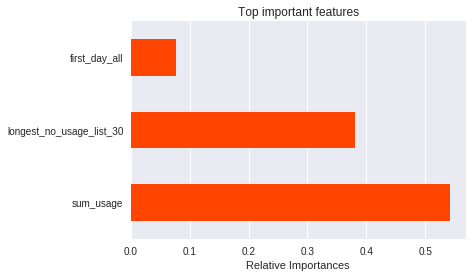

In [101]:
ind0=np.where(clf0.feature_importances_>0.02)
z0=clf0.feature_importances_[ind0]

pdf0 = pd.DataFrame(columns=['import','name','std'])
pdf0['import']=z0
pdf0['name'] = pd.Series(X.columns[ind0], index=pdf0.index)
pdf0['std'] = pd.Series(std[ind0], index=pdf0.index)
pdf10=pdf0.sort_values(['import'], ascending=False)


pdf10.plot(x='name', y='import',kind='barh',color='orangered',legend=False,title='Top important features')
#plt.xticks(rotation=50)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_label_text('Relative Importances')
y_axis = ax1.axes.get_yaxis()
y_axis.set_label_text('')
ax1.yaxis.grid(False)
plt.show()



In [ ]:
ind0=np.where(clf0.feature_importances_<0.02)
z0=clf0.feature_importances_[ind0]

pdf0 = pd.DataFrame(columns=['import','name','std'])
pdf0['import']=z0
pdf0['name'] = pd.Series(X.columns[ind0], index=pdf0.index)
pdf0['std'] = pd.Series(std[ind0], index=pdf0.index)
pdf10=pdf0.sort_values(['import'], ascending=False)


pdf10.plot(x='name', y='import',kind='barh',color='y',legend=False,title='Least important features')
#plt.xticks(rotation=50)
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_label_text('Relative Importances')
y_axis = ax1.axes.get_yaxis()
y_axis.set_label_text('')
ax1.yaxis.grid(False)
plt.show()


## Perform grid search with 5 fold CV to optimize for accuracy

In [109]:
param_grid = {'n_estimators': [120,240,260,300,360], 
              'max_depth': [8,12,20,30],
              'min_samples_leaf':[2,4,5,6],
               'criterion':['entropy','gini']
              }

# Setup 5 fold cross validation over grid search
clf1 = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring=make_scorer(accuracy_score),n_jobs=-1) 
clf1.fit(X_train0, y_train0)

print("Grid scores on development set:")
means = clf1.cv_results_['mean_test_score']
stds = clf1.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std*2, params))

print("Best parameters set found on development set:")
print(clf1.best_params_)
print("Best Score found on development set:")
print(clf1.best_score_)

Grid scores on development set:
0.827 (+/-0.015) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 120}
0.826 (+/-0.017) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 240}
0.827 (+/-0.016) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 260}
0.827 (+/-0.016) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 300}
0.826 (+/-0.012) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 360}
0.826 (+/-0.016) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 120}
0.825 (+/-0.019) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 240}
0.825 (+/-0.018) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 260}
0.826 (+/-0.018) for {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4, 'n_estimators': 300}
0.826 (+/-0.01

In [110]:
    print ("Trained model :: ", clf1)
    predictions1 = clf1.predict(X_test0)
 
    print ("Train Accuracy :: ", accuracy_score(y_train0, clf1.predict(X_train0)))
    print ("Test Accuracy  :: ", accuracy_score(y_test0, predictions1))
    print ("Confusion matrix ", confusion_matrix(y_test0, predictions1))
    print ("F1 score ", f1_score(y_test0, predictions1))
    print ('Recall:', recall_score(y_test0, predictions1))
    print ('Precision:', precision_score(y_test0, predictions1))

Trained model ::  GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [120, 240, 260, 300, 360], 'max_depth': [8, 12, 20, 30], 'min_samples_leaf': [2, 4, 5, 6], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)
Train Accuracy ::  0.8404558404558404
Test Accuracy  ::  0.8222049689440993
Confusion matrix  [[123 213]
 [ 16 936]]
F1 score  0.8910042836744407
Recall: 0.9831932773109243
